Szymon Rogowski (405244)
Laboratorium 4

In [136]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

print("Libs loaded.")

Libs loaded.


1.

In [137]:
image_hubble_path = "images/hubble.jpg"
original_image = cv2.imread(image_hubble_path, cv2.IMREAD_GRAYSCALE)

In [138]:
def process_and_plot_diff(image, num_images_to_average, mean, std_dev):
    sum = np.zeros_like(image, dtype=np.float64)
    for num_images in num_images_to_average:
        for _ in range(num_images):
            noise_std = (np.clip(image + np.random.normal(mean, std_dev, image.shape), 0, 255)).astype(np.uint8)
            sum += noise_std

        averaged = sum + sum / num_images
        diff_image = np.abs(image - averaged)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].imshow(diff_image, cmap='gray', vmin=0, vmax=255)
        axes[0].set_title(f'Difference (Avg of {num_images} Images)')

        axes[1].hist(diff_image.flatten(), bins=256, range=[0, 256], density=True, color='r', alpha=0.7)
        axes[1].set_title(f'Histogram of Difference (Avg of {num_images} Images)')

        plt.show()

In [139]:
std_dev1, std_dev2, mean = 20, 40, 0
num_images_to_average = [8, 16, 32, 64]

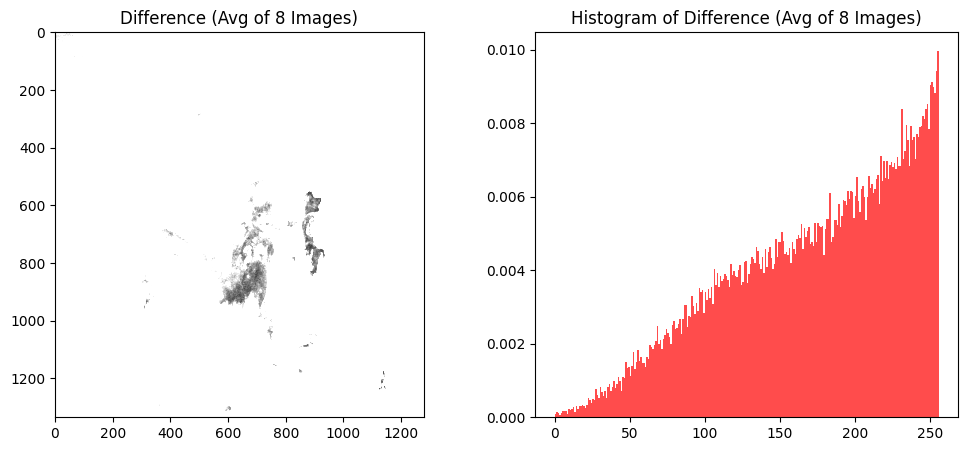

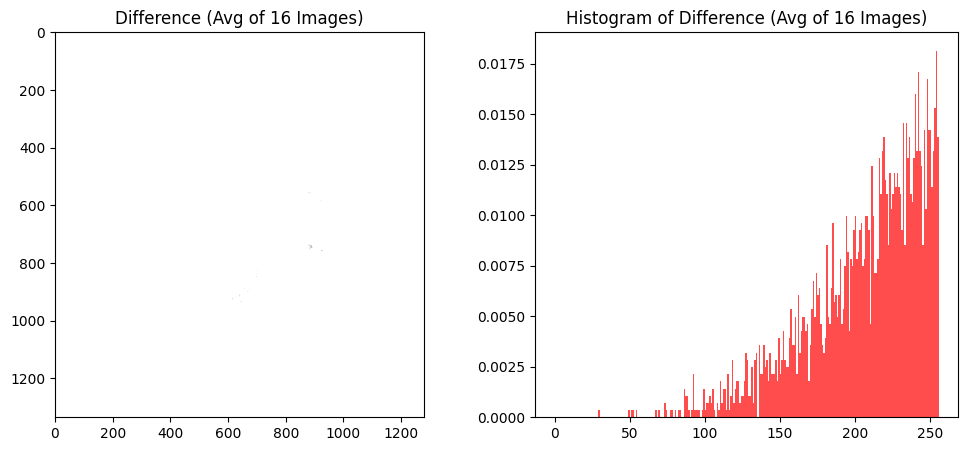

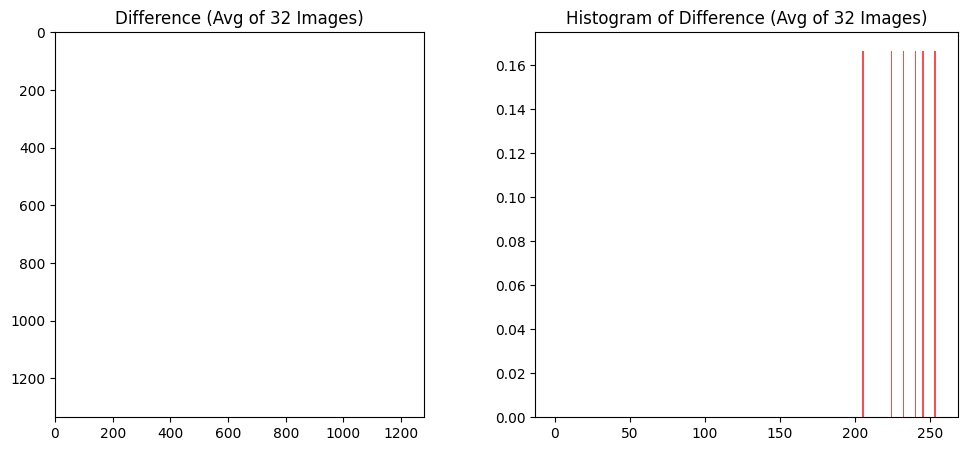

C:\Users\szymo\PycharmProjects\ImageProcessing\venv\lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


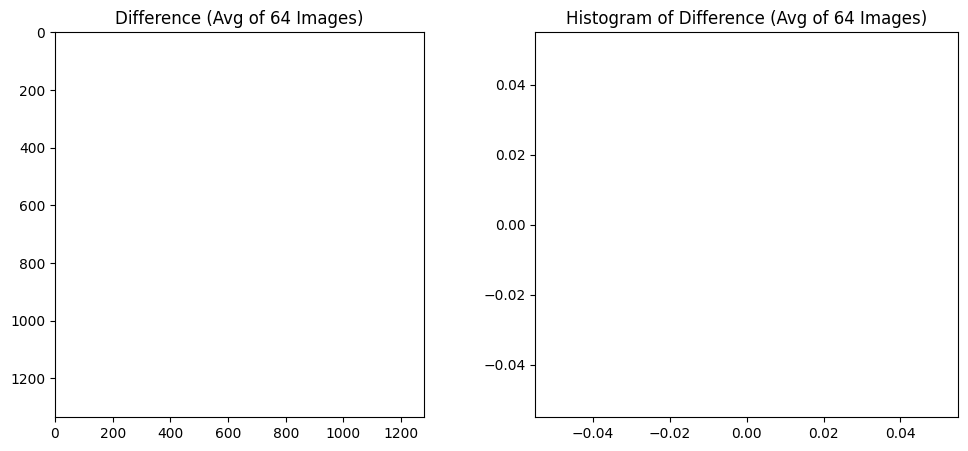

In [140]:
process_and_plot_diff(original_image, num_images_to_average, mean, std_dev1)